(pymc_overview)=

# Introductory Overview of PyMC

Note: This text is partly based on the [PeerJ CS publication on PyMC](https://peerj.com/articles/cs-55/) by John Salvatier, Thomas V. Wiecki, and Christopher Fonnesbeck.

:::{post} 21 December, 2021
:tags: exploratory analysis, glm, mcmc, pymc.Data, pymc.Deterministic, pymc.DiscreteUniform, pymc.Exponential, pymc.HalfStudentT, pymc.InverseGamma, pymc.HalfNormal, pymc.Model, pymc.Normal, pymc.Poisson, pymc.Slice, pymc.StudentT
:category: beginner
:::

## Abstract

Probabilistic Programming allows for automatic Bayesian inference on user-defined probabilistic models. Gradient-based algorithms for Markov chain Monte Carlo (MCMC) sampling, known as Hamiltonian Monte Carlo (HMC), allow inference on increasingly complex models but requires gradient information that is often not trivial to calculate PyMC is an open source Probabilistic Programming framework written in Python that uses Aesara to compute gradients via automatic differentiation as well as compile probabilistic programs on-the-fly to one of a suite of computational backends for increased speed. PyMC allows for model specification in Python code, rather than im a domain specific language, making it easy to learn, customize, and debug. This paper is a tutorial-style introduction to this software package for those already somewhat familiar with Bayesian statistics.

## Introduction

Probabilistic programming (PP) allows flexible specification of Bayesian statistical models in code. PyMC is a PP framework with an intuitive and readable, yet powerful, syntax that is close to the natural syntax statisticians use to describe models. It features next-generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). This class of samplers works well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms. HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo, which means you usually don't need to have specialized knowledge about how the algorithms work. 

Probabilistic programming in Python confers a number of advantages including multi-platform compatibility, an expressive yet clean and readable syntax, easy integration with other scientific libraries, and extensibility via C, C++, Fortran or Cython. These features make it relatively straightforward to write and use custom statistical distributions, samplers and transformation functions, as required by Bayesian analysis.

While most of PyMC's user-facing features are written in pure Python, it leverages Aesara (a fork of the Theano project) to transparently transcode models to C and compile them to machine code, thereby boosting performance. Aesara is a library that allows expressions to be defined using generalized vector data structures called *tensors*, which are tightly integrated with the popular NumPy {class}`~numpy.ndarray` data structure, and similarly allow for broadcasting and advanced indexing, just as NumPy arrays do. Aesara also automatically optimizes the likelihood's computational graph for speed and allows for compilation to a suite of computational backends, including Jax and Numba.

Here, we present a primer on the use of PyMC for solving general Bayesian statistical inference and prediction problems. We will first see the basics of how to use PyMC, motivated by a simple example: installation, data creation, model definition, model fitting and posterior analysis. Then we will cover two case studies and use them to show how to define and fit more sophisticated models. Finally we will  discuss a couple of other other useful features: custom distributions and arbitrary deterministic nodes.

## Installation

Running PyMC requires a relatively recent Python interpreter, preferrably version 3.8 or greater. A complete Python installation for Mac OSX, Linux and Windows can most easily be obtained by downloading and installing the free [`Anaconda Python Distribution`](https://store.continuum.io/cshop/anaconda/) by ContinuumIO or the open source [Miniforge](https://github.com/conda-forge/miniforge).

Once Python is installed, follow the  {ref}`platform-specific installation guides <installation>` on the PyMC GitHub repository.

PyMC is distributed under the liberal [Apache License 2.0](https://github.com/pymc-devs/pymc/blob/master/LICENSE). On the GitHub site, users may also report bugs and other issues, as well as contribute documentation or code to the project, which we actively encourage.

## A Motivating Example: Linear Regression

To introduce model definition, fitting, and posterior analysis, we first consider a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$.

$$\begin{aligned} 
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}$$

where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X_i$, while $\sigma$ represents the observation error. Since we are constructing a Bayesian model, we must assign a prior distribution to the unknown variables in the model. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to *weak* information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.

$$\begin{aligned} 
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}$$

### Generating data

We can simulate some artificial data from this model using only NumPy's {mod}`~numpy.random` module, and then use PyMC to try to recover the corresponding parameters. We are intentionally generating the data to closely correspond the PyMC model structure.

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

Here is what the simulated data look like. We use the `pylab` module from the plotting library matplotlib. 

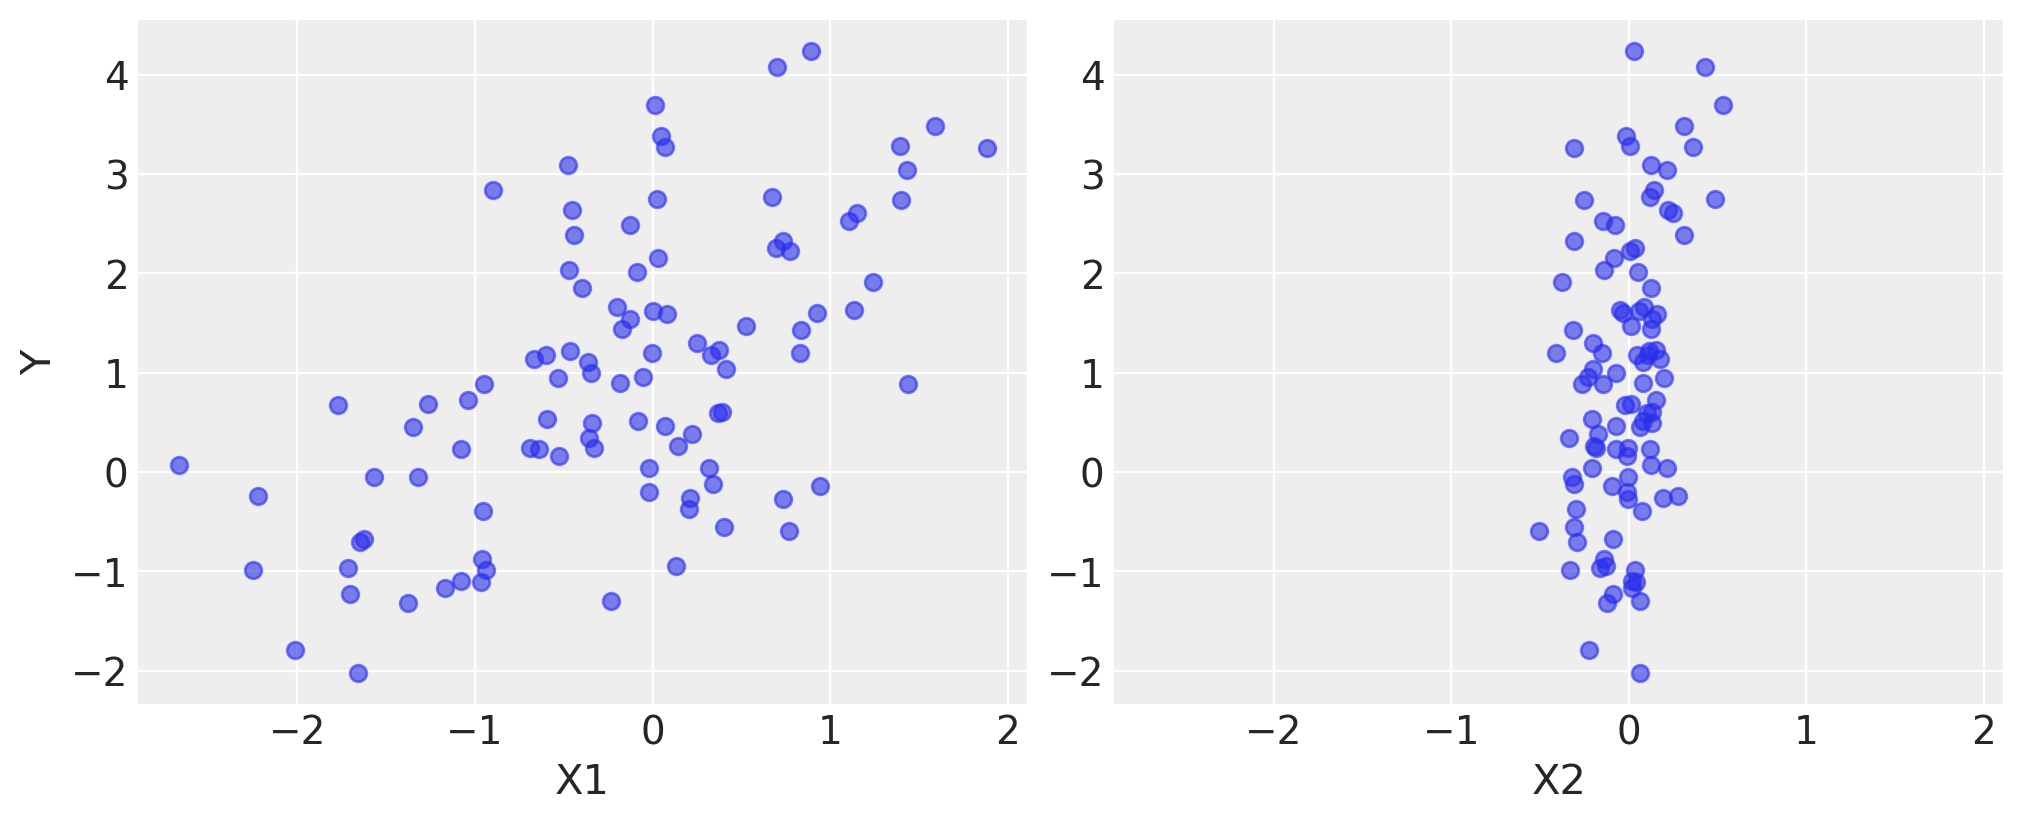

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

### Model Specification

Specifying this model in PyMC is straightforward because the syntax is as close to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above. 

First, we import PyMC. We use the convention of importing it as `pm`.

In [5]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.0.0b1


Now we build our model, which we will present in full first, then explain each part line-by-line.

In [6]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

The first line,

```python
basic_model = pm.Model()
```

creates a new {class}`~pymc.Model` object which is a container for the model random variables.

Following instantiation of the model, the subsequent specification of the model components is performed inside a  `with` statement:

```
with basic_model:
```
This creates a *context manager*, with our `basic_model` as the context, that includes all statements until the indented block ends. This means all PyMC objects introduced in the indented code block below the `with` statement are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with `basic_model` right after we create them. If you try to create a new random variable without a `with model:` statement, it will raise an error since there is no obvious model for the variable to be added to.

The first three statements in the context manager:

```python
alpha = pm.Normal('alpha', mu=0, sigma=10)
beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
sigma = pm.HalfNormal('sigma', sigma=1)
```
create **stochastic** random variables with Normal prior distributions for the regression coefficients with a mean of 0 and standard deviation of 10, and a half-normal distribution for the standard deviation of the observations, $\sigma$. These are stochastic because their values are partly determined by its parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic). 

We call the `pm.Normal` constructor to create a random variable to use as a normal prior. The first argument is always the *name* of the random variable, which should almost always match the name of the Python variable being assigned to, since it is sometimes used to retrieve the variable from the model for summarizing output. The remaining required arguments for a stochastic object are the parameters, in this case `mu`, the mean, and `sd`, the standard deviation, which we assign hyperparameter values for the model. In general, a distribution's parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly-used distributions, such as `Beta`, `Exponential`, `Categorical`, `Gamma`, `Binomial` and many others, are available in PyMC.

The `beta` variable has an additional `shape` argument to denote it as a vector-valued parameter of size 2. The `shape` argument is available for all distributions and specifies the length or shape of the random variable, but is optional for scalar variables, since it defaults to a value of one. It can be an integer, to specify an array, or a tuple, to specify a multidimensional array (*e.g.* `shape=(5,7)` makes random variable that takes on 5 by 7 matrix values). 

Detailed notes about distributions, sampling methods and other PyMC functions are available in the {ref}`API documentation <api>`.

Having defined the priors, the next statement creates the expected value `mu` of the outcomes, specifying the linear relationship:

```python
mu = alpha + beta[0]*X1 + beta[1]*X2
```
This creates a **deterministic** random variable, which implies that its value is *completely* determined by its parents' values. That is, there is no uncertainty beyond that which is inherent in the parents' values. Here, `mu` is just the sum of the intercept `alpha` and the two products of the coefficients in `beta` and the predictor variables, whatever their values may be. 

PyMC random variables and data can be arbitrarily added, subtracted, divided, multiplied together and indexed-into to create new random variables. This allows for great model expressivity. Many common mathematical functions like `sum`, `sin`, `exp` and linear algebra functions like `dot` (for inner product) and `inv` (for inverse) are also provided. 

The final line of the model, defines `Y_obs`, the sampling distribution of the outcomes in the dataset.

```python
Y_obs = Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
```

This is a special case of a stochastic variable that we call an **observed stochastic**, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its `observed` argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a {class}`~numpy.ndarray` or {class}`~pandas.DataFrame` object.

Notice that, unlike for the priors of the model, the parameters for the normal distribution of `Y_obs` are not fixed values, but rather are the deterministic object `mu` and the stochastic `sigma`. This creates parent-child relationships between the likelihood and these two variables.

In [7]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/fonnesbeck/miniforge3/envs/dev/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
/home/fonnesbeck/miniforge3/envs/dev/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


The {mod}`~pymc.sample` function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns an {class}`~arviz.InferenceData` object containing the samples collected, along with other useful attributes like statistics of the sampling run and a copy of the observed data. Notice that `sample` generated a set of parallel chains, depending on how many compute cores are on your machine.

In [8]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

The various attributes of the `InferenceData` object can be queried in a similar way to a `dict` containing a map from variable names to `numpy.array`s. For example, we can retrieve the sampling trace from the `alpha` latent variable by using the variable name as an index to the `idata.posterior` attribute. The first dimension of the returned array is the chain index, the second dimension is the sampling index, while the later dimensions match the shape of the variable. We can see the first 5 values for the `alpha` variable in each chain as follows:

In [9]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[1.14113159, 1.123597  , 1.31582516, 1.2346751 , 1.11823746],
       [1.19919283, 1.02823256, 1.23043262, 1.22339513, 1.23036168],
       [1.1750769 , 1.27557257, 1.17949927, 1.11453054, 1.20707487],
       [1.26425982, 1.25269245, 1.37856558, 1.04335419, 1.02215125]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

If we wanted to use the slice sampling algorithm to `sigma` instead of NUTS (which was assigned automatically), we could have specified this as the `step` argument for `sample`.

In [10]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]
/home/fonnesbeck/miniforge3/envs/dev/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 15 seconds.


### Posterior analysis
`PyMC`'s plotting and diagnostics functionalities are now taken care of by a dedicated, platform-agnostic package named [ArviZ](https://arviz-devs.github.io/arviz/). A simple posterior plot can be created using {mod}`~arviz.plot_trace`.

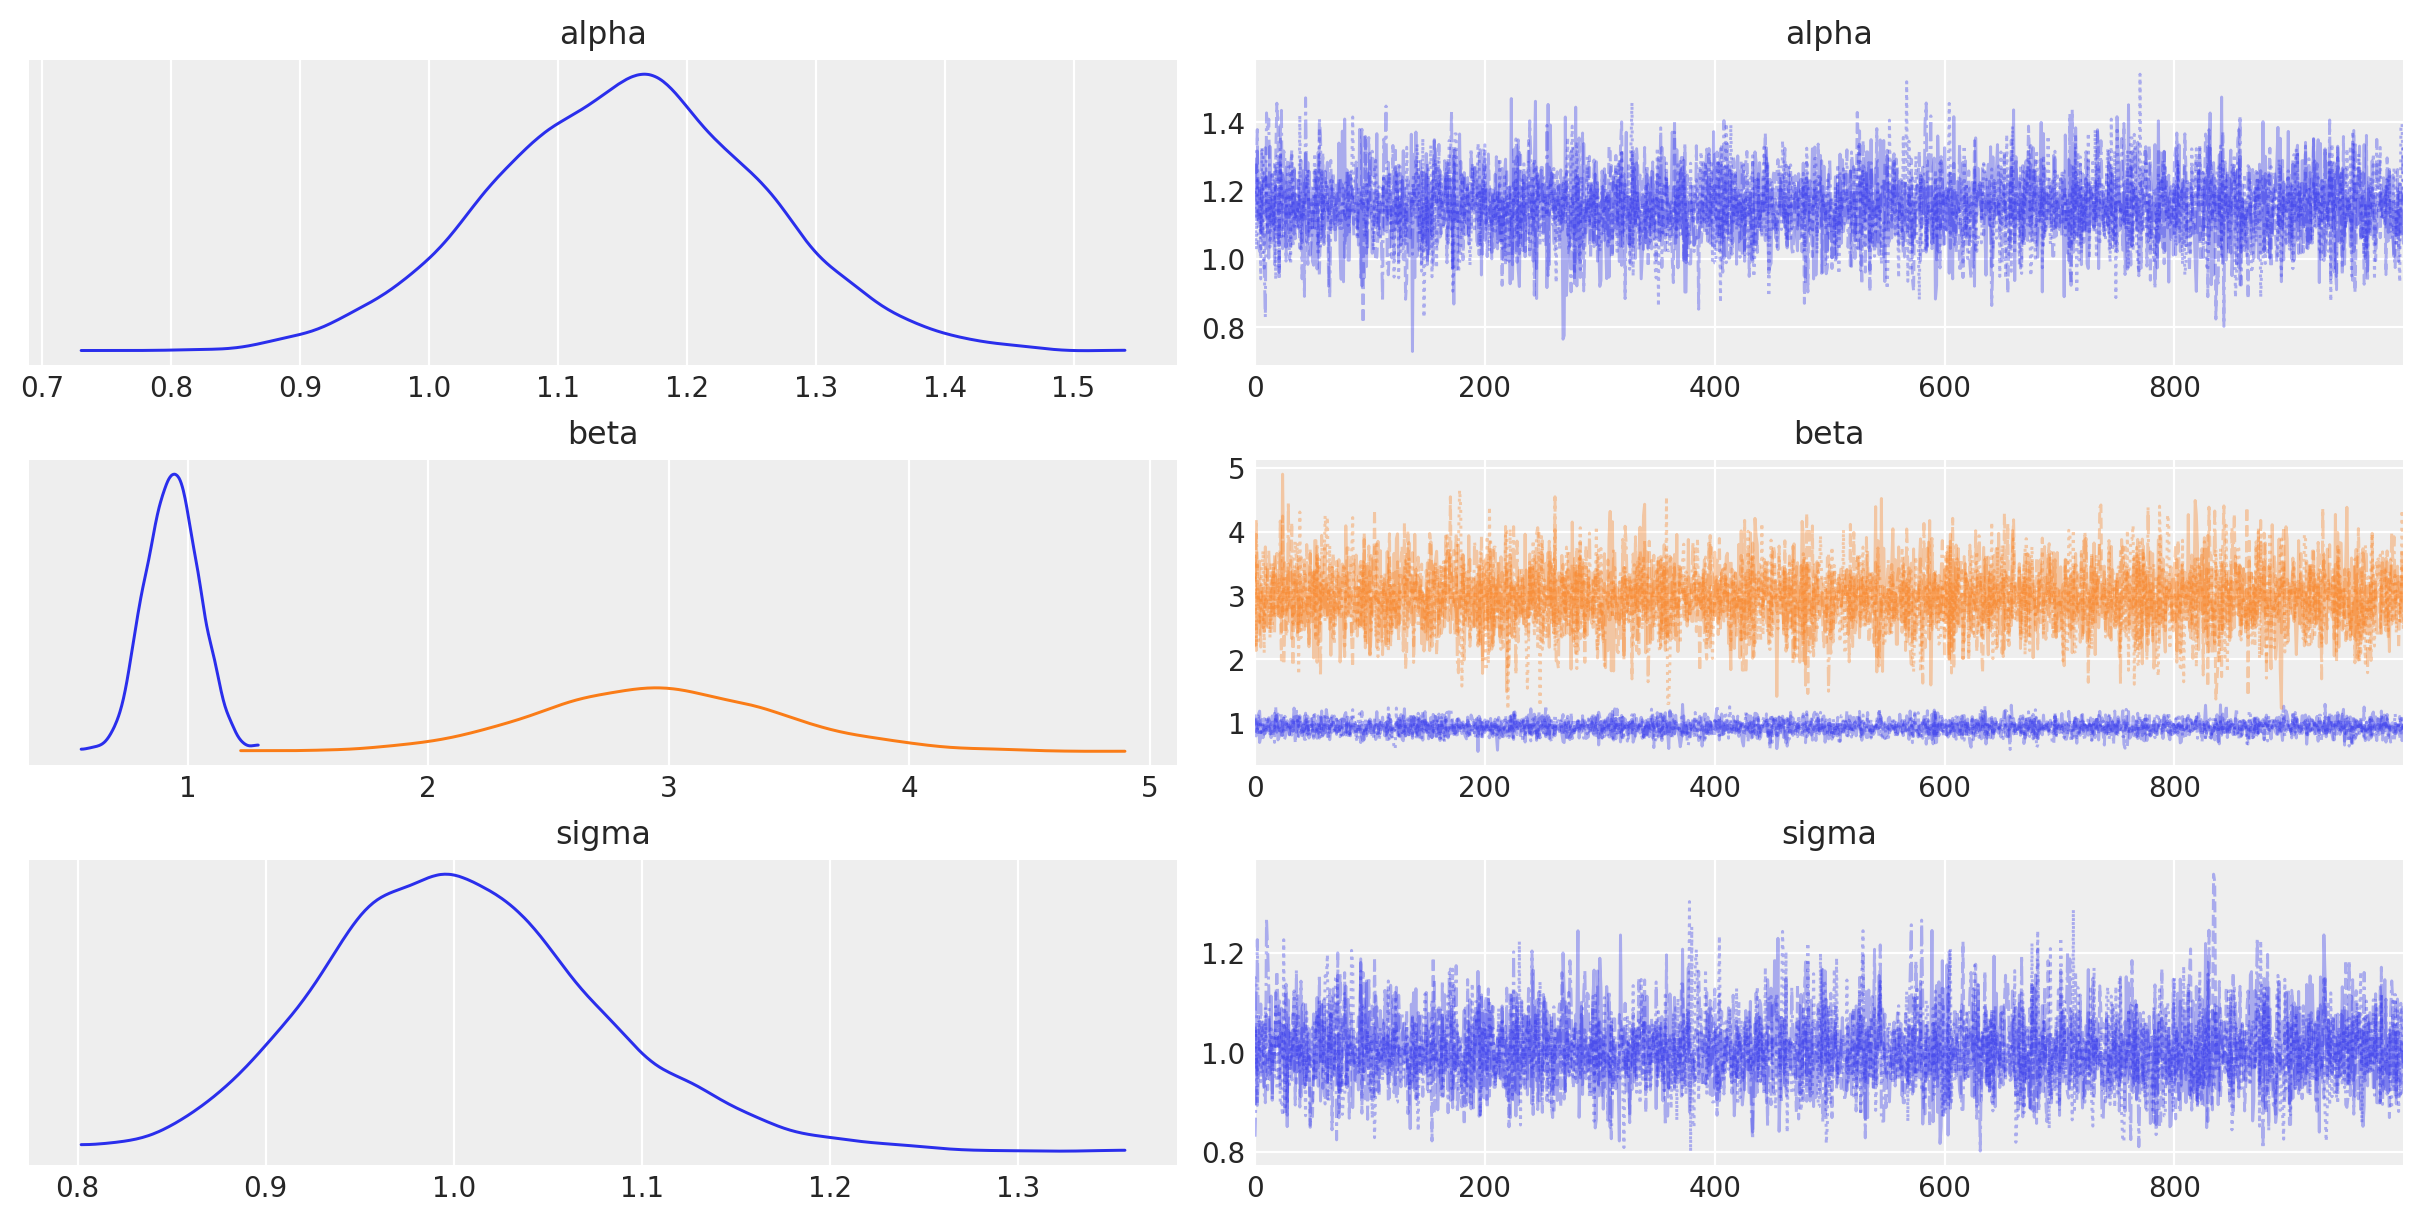

In [11]:
az.plot_trace(idata, combined=True);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The `beta` variable, being vector-valued, produces two density plots and two trace plots, corresponding to both predictor coefficients.

In addition, the {mod}`~arviz.summary` function provides a text-based output of common posterior statistics:

In [12]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.15,0.11,0.94,1.34,0.00,0.0,5785.16,3133.43,1.0
beta[0],0.94,0.11,0.74,1.14,0.00,0.0,5807.69,3167.57,1.0
beta[1],2.96,0.51,1.98,3.90,0.01,0.0,6260.69,2960.06,1.0
sigma,1.00,0.07,0.87,1.15,0.00,0.0,5792.29,2851.20,1.0


## Case study 1: Educational Outcomes for Hearing-impaired Children

As a motivating example, we will use a dataset of educational outcomes for children with hearing impairment. Here, we are interested in determining factors that are associated with better or poorer learning outcomes. 

### The Data

This anonomized dataset is taken from the Listening and Spoken Language Data Repository (LSL-DR), an international data repository that tracks the demographics and longitudinal outcomes for children who have hearing loss and are enrolled programs focused on supporting listening and spoken language development. Researchers are interesting in discovering factors related to improvements in educational outcomes at within these programs.

There is a suite of available predictors, including: 

* gender (`male`)
* number of siblings in the household (`siblings`)
* index of family involvement (`family_inv`)
* whether the primary household language is not English (`non_english`)
* presence of a previous disability (`prev_disab`)
* non-white race (`non_white`)
* age at the time of testing (in months, `age_test`)
* whether hearing loss is not severe (`non_severe_hl`)
* whether the subject's mother obtained a high school diploma or better (`mother_hs`)
* whether the hearing impairment was identified by 3 months of age (`early_ident`).

The outcome variable is a standardized test score in one of several learning domains.

In [13]:
test_scores = pd.read_csv(pm.get_data('test_scores.csv'), index_col=0)
test_scores.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


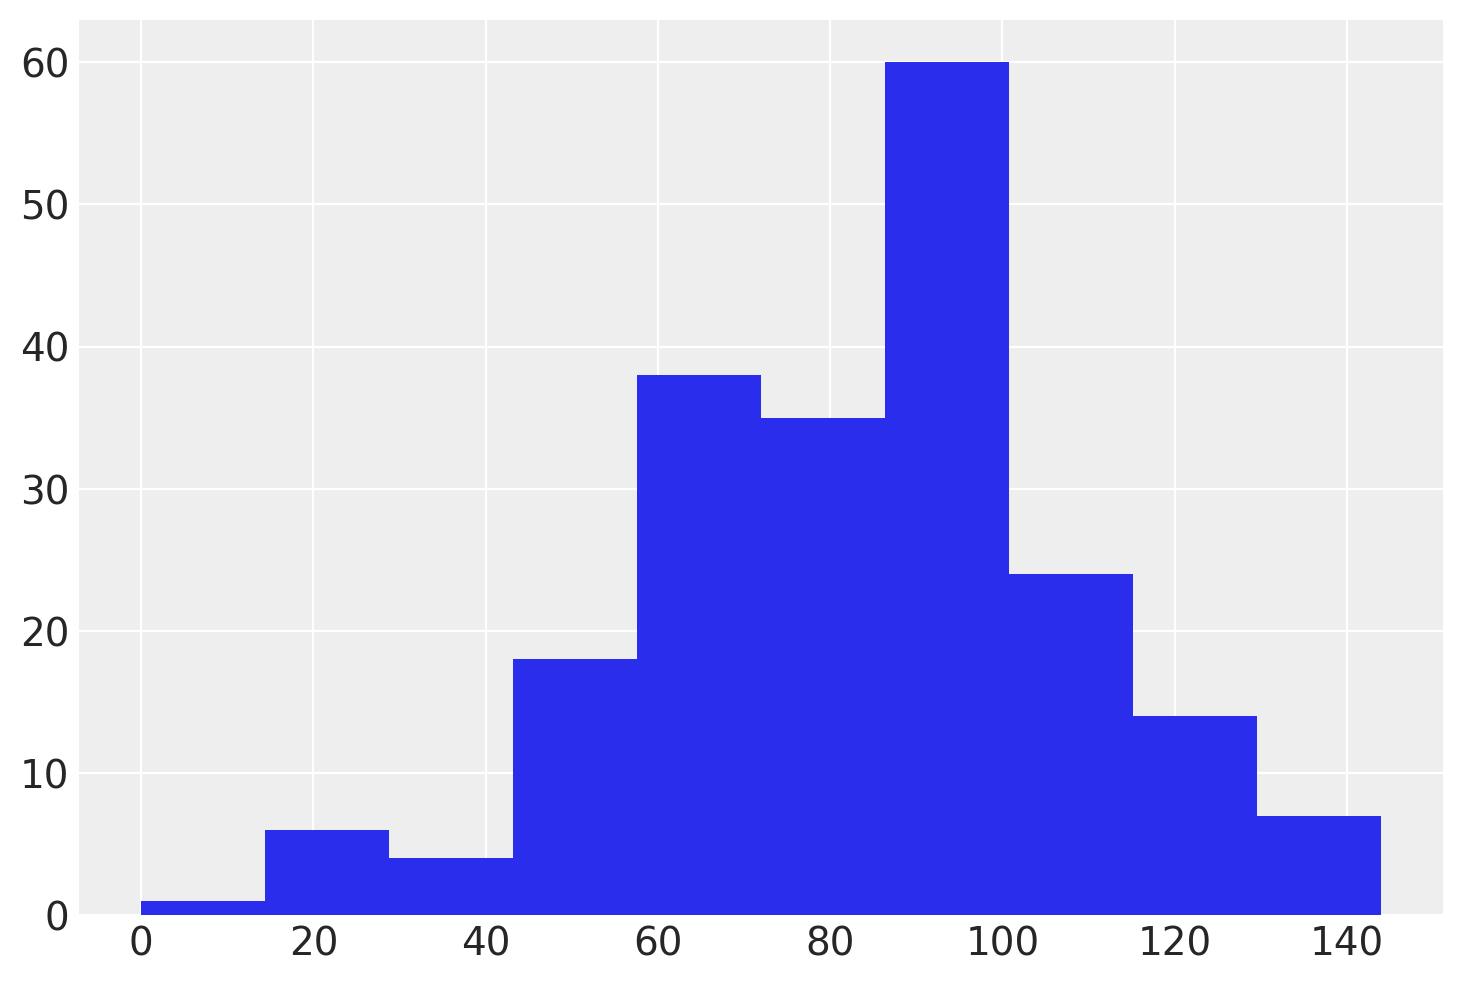

In [14]:
test_scores["score"].hist();

In [15]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

### The Model

This is a more realistic problem than the first regression example, as we are now dealing with a **multivariate regression** model. However, while there are several potential predictors in the LSL-DR dataset, it is difficult *a priori* to determine which ones are relevant for constructing an effective statistical model. There are a number of approaches for conducting variable selection, but a popular automated method is *regularization*, whereby ineffective covariates are shrunk towards zero via regularization (a form of penalization) if they do not contribute to predicting outcomes. 

You may have heard of regularization from machine learning or classical statistics applications, where methods like the lasso or ridge regression shrink parameters towards zero by applying a penalty to the size of the regression parameters. In a Bayesian context, we apply an appropriate prior distribution to the regression coefficients. One such prior is the *hierarchical regularized horseshoe*, which uses two regularization strategies, one global and a set of local local parameters, one for each coefficient. The key to making this work is by selecting a long-tailed distribution as the shrinkage priors, which allows some to be nonzero, while pushing the rest towards zero.

The horeshoe prior for each regression coefficient $\beta_i$ looks like this:

$$\beta_i \sim N\left(0, \tau^2 \cdot \tilde{\lambda}_i^2\right)$$

where $\sigma$ is the prior on the error standard deviation that will also be used for the model likelihood.

Where $\tau$ is the global shrinkage parameter and $\tilde{\lambda}_i$ is the local. Let's start global: for the prior on $\tau$ we will use a Half-StudentT distribution, which is a reasonable choice becuase it is heavy-tailed.

$$
\tau \sim \textrm{Half-StudentT}_{2} \left(\frac{D_0}{D - D_0} \cdot \frac{\sigma}{\sqrt{N}}\right).
$$

One catch is that the parameterization of the prior requires a pre-specified value $D_0$, which represents the true number of non-zero coefficients. Fortunately, a reasonable guess at this value is all that is required, and it need only be within an order of magnitude of the true number. Let's use half the number of predictors as our guess:

In [16]:
D0 = int(D/2)

Meanwhile, the local shrinkage parameters are defined by the ratio:

$$\tilde{\lambda}_i^2 = \frac{c^2 \lambda_i^2}{c^2 + \tau^2 \lambda_i^2}.$$

To complete this specification, we need priors on $\lambda_i$ and $c$;  as with the global shrinkage, we use a long-tailed $\textrm{Half-StudentT}_5(1)$  on the $\lambda_i$. We need $c^2$ to be strictly positive, but not necessarily long-tailed, so an inverse gamma prior on $c^2$, $c^2 \sim \textrm{InverseGamma}(1, 1)$ fits the bill.

Finally, to allow the NUTS sampler to sample the $\beta_i$ more efficiently, we will re-parameterize it as follows:

$$
\begin{align*}
    z_i
        & \sim N(0, 1), \\
     \beta_i
         & = z_i \cdot \tau \cdot \tilde{\lambda_i}.
\end{align*}
$$

You will run into this reparameterization a lot in practice.


### Model Specification

Specifying the model in PyMC mirrors its statistical specification. This model employs a couple of new distributions: the {class}`~pymc.HalfStudentT` distribution for the $\tau$ and $\lambda$ priors, and the `InverseGamma` distribution for the $c2$ variable.

In PyMC, variables with purely positive priors like {class}`~pymc.InverseGamma` are transformed with a log transform. This makes sampling more robust. Behind the scenes, a variable in the unconstrained space (named `<variable-name>_log`) is added to the model for sampling. Variables with priors that constrain them on two sides, like {class}`~pymc.Beta` or {class}`~pymc.Uniform`, are also transformed to be unconstrained but with a log odds transform. 

We are also going to take advantage of named dimensions in PyMC and ArviZ by passing the input variable names into the model as coordinates called "predictors". This will allow us to pass this vector of names as a replacement for the `shape` integer argument in the vector-valued parameters. The model will then associate the appropriate name with each latent parameter that it is estimating. This is a little more work to set up, but will pay dividends later when we are working with our model output.

Let's encode this model in PyMC:

In [17]:
import aesara.tensor as at

with pm.Model(coords={"predictors":X.columns.values}) as test_score_model:

    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 2, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 0.1)
    z = pm.Normal("z", 0., 1., dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic("beta", z * tau * lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors")
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.)
    
    scores = pm.Normal("scores", beta0 + at.dot(X.values, beta), sigma, observed=y.values)

Notice that we have wrapped the calculation of `beta` in a {class}`~pymc.Deterministic` PyMC class. You can read more about this in detail below, but this ensures that the values of this deterministic variable is retained in the sample trace.

Also note that we have declared the {class}`~pymc.Model` name `test_score_model` in the first occurrence of the context manager, rather than splitting it into two lines, as we did for the first example.

Once the model is complete, we can look at its stucture using GraphViz, which plots the model graph. Its useful to ensure that the relationships in the model you have coded are correct, as its easy to make coding mistakes.

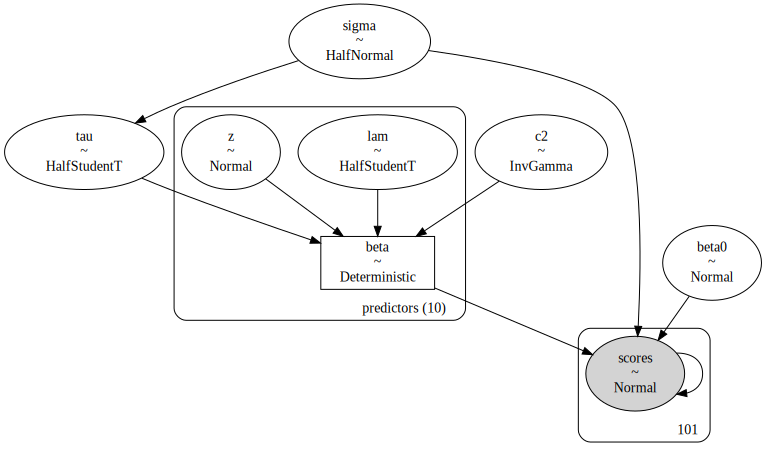

In [18]:
pm.model_to_graphviz(test_score_model)

Before we proceed further, let's see what the model does before it sees any data. We can conduct *prior predictive sampling* to generate simulated data from the model. Then, let's compare these simulations to the actual test scores in the dataset.

In [19]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

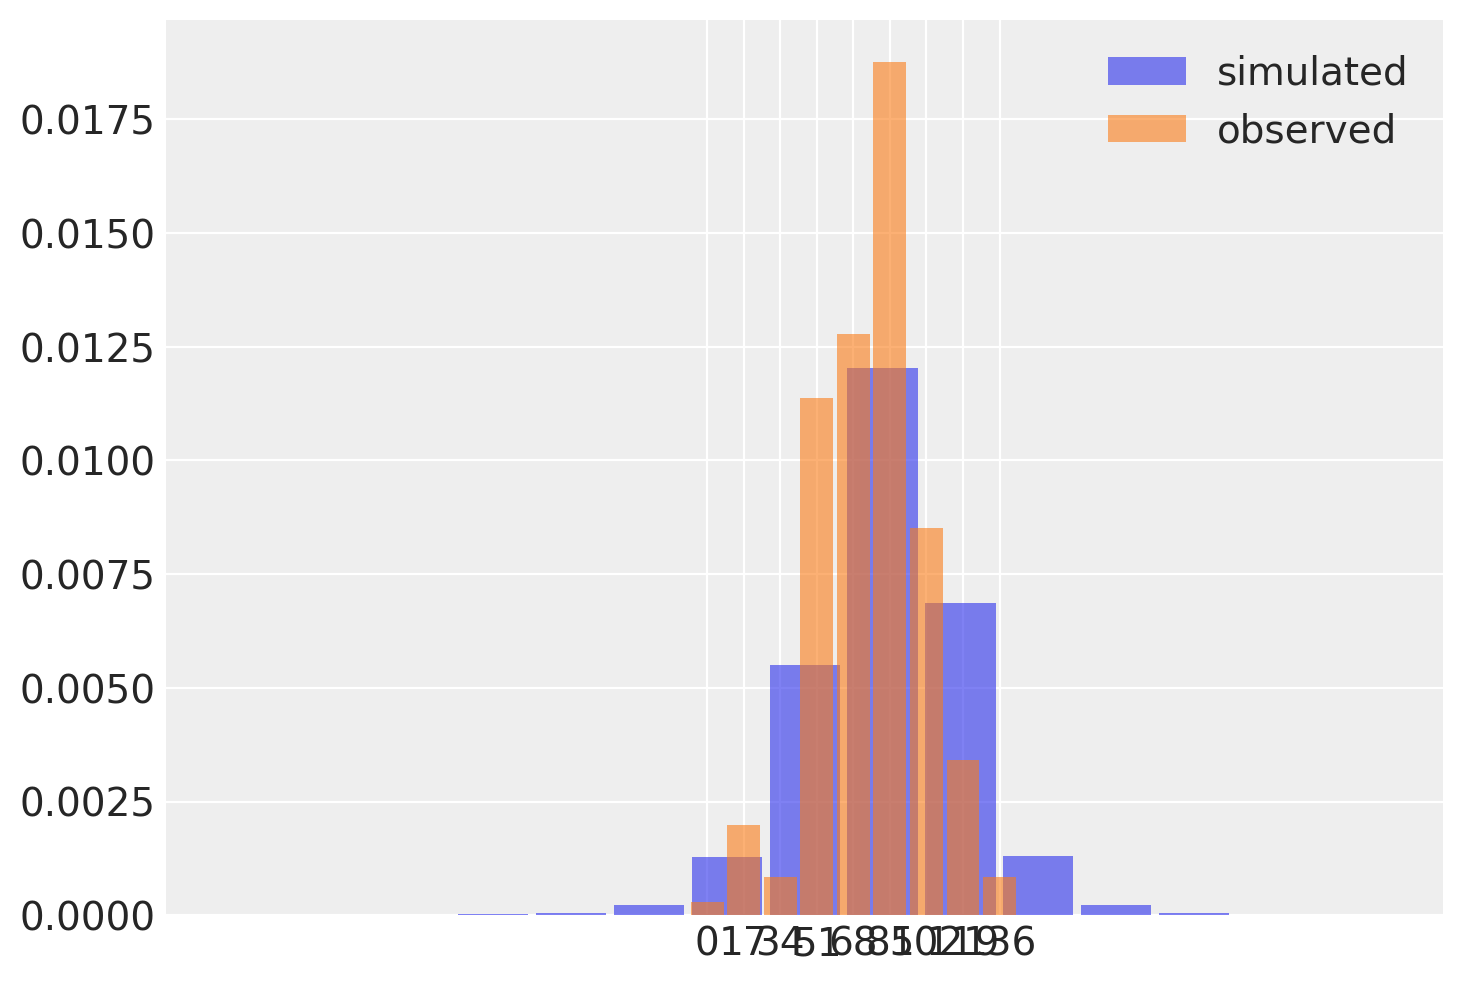

In [36]:
az.plot_dist(prior_samples.prior_predictive["scores"], kind="hist", hist_kwargs=dict(alpha=0.6), label="simulated")
az.plot_dist(test_scores["score"].values, kind="hist", color='C1', hist_kwargs=dict(alpha=0.6), label="observed");


How do we know if this is reasonable or not? This requires some domain knowledge of the problem. Here, we are trying to predict the outcomes of test scores. If our model was predicting values in the thousands, or lots of negative values, while excluding scores that are plausible, then we have misspecified our model. You can see here that the support of the distribution of simulated data completely overlaps the support of the observed distribution of scores; this is a good sign! There are a few negative values and a few that are probably too large to be plausible, but nothing to worry about. 

### Model Fitting

Now for the easy part: PyMC's "Inference Button" is the call to `sample`. We will let this model tune for a little longer than the default value (1000 iterations). This gives the NUTS sampler a little more time to tune itself adequately.

In [21]:
with test_score_model:

    idata = pm.sample(1000, tune=2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/fonnesbeck/miniforge3/envs/dev/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6982, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Notice that we have a few warnings here about divergences. These are samples where NUTS was not able to make a valid move across the posterior distribution, so the resulting points are probably not representative samples from the posterior. There aren't many in this example, so its nothing to worry about, but let's go ahead and follow the advice and increase `target_accept` from its default value of 0.9 to 0.99.

In [22]:
with test_score_model:

    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/fonnesbeck/miniforge3/envs/dev/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 46 seconds.


Since the target acceptance rate is larger, the algorithm is being more conservative with its leapfrog steps, making them smaller. The price we pay for this is that each sample takes longer to complete. However, the warnings are now gone, and we have a clean posterior sample!

#### Model Checking

A simple first step in model checking is to visually insepct our samples by looking at the traceplot for the univariate latent parameters to check for obvious problems. These names can be passed to `plot_trace` in the `var_names` argument.

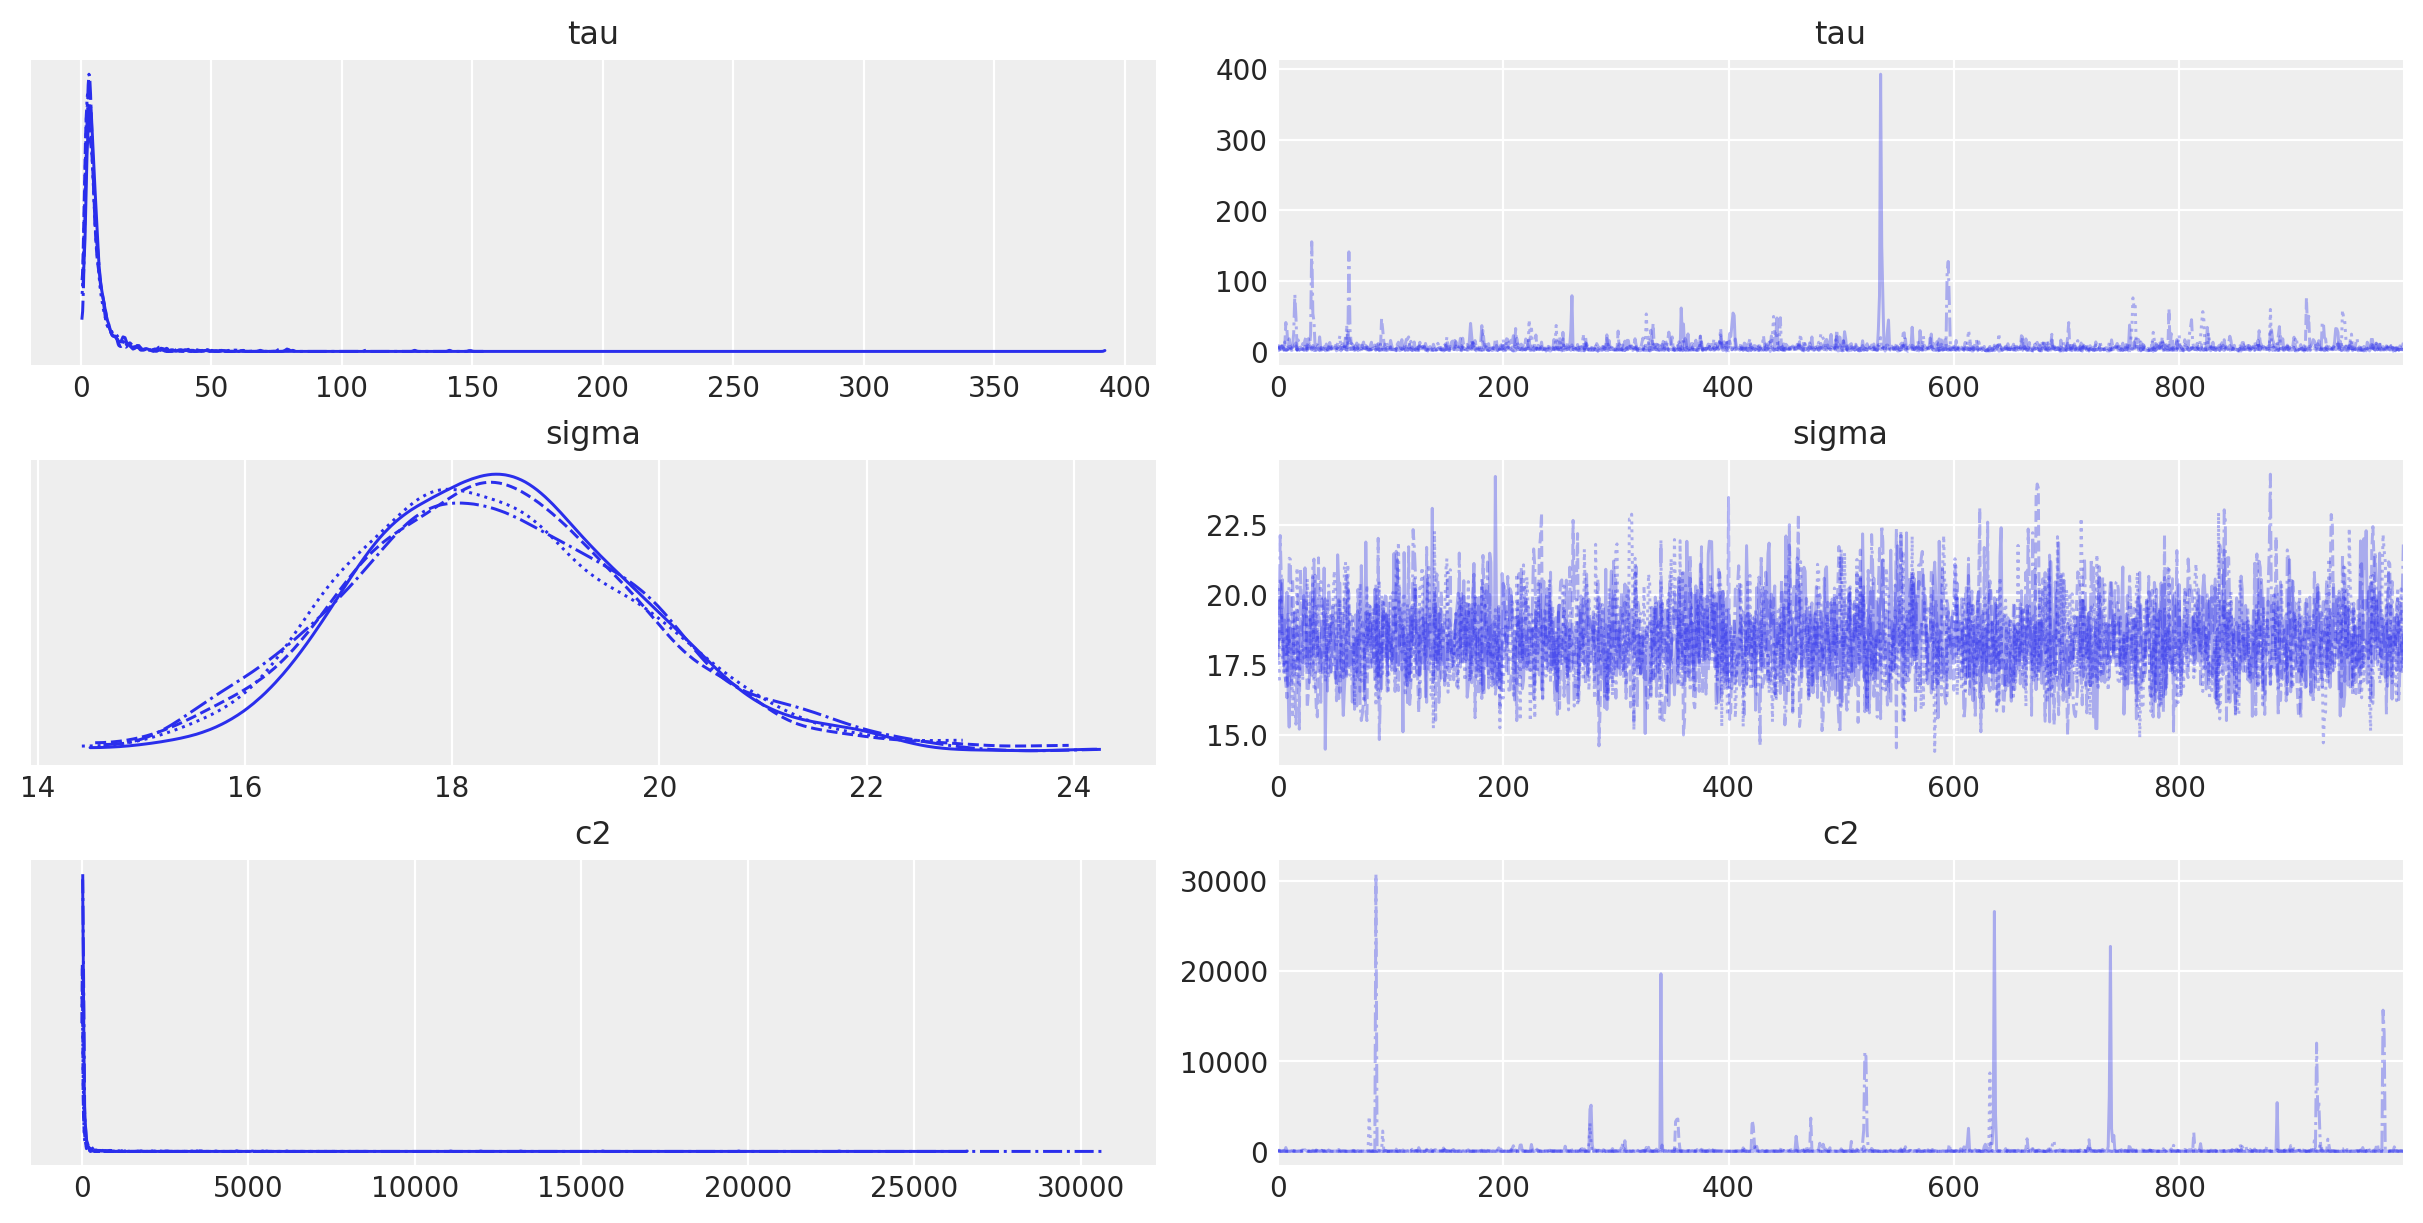

In [23]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"]);

Do these look okay? Well, each of the densities on the left side for each parameter looks pretty similar to the others, which means they have converged to the same posterior distribution (be it the correct one or not). The homogeneity of the trace plots on the right are also a good sign; there is no trend or pattern to the time series of sampled values. Note that `c2` and `tau` occasionally sample extreme values, but this is expected from heavy-tailed distributions. 

The next easy model checking step is to see if the NUTS sampler performed as expected. An energy plot is a way of checking if the NUTS algorithm was able to adequately explore the posterior distribtion. If it was not, one runs the risk of biased posterior estimates when parts of the posterior are not visited with adequate frequency. The plot shows two density estimates, one is the marginal energy distribution of the sampling run and the other is the distribution of the energy transitions between steps. This is all a little abstract, but all we are looking for is for the distributions to be similar to one another. Ours does not look too bad.

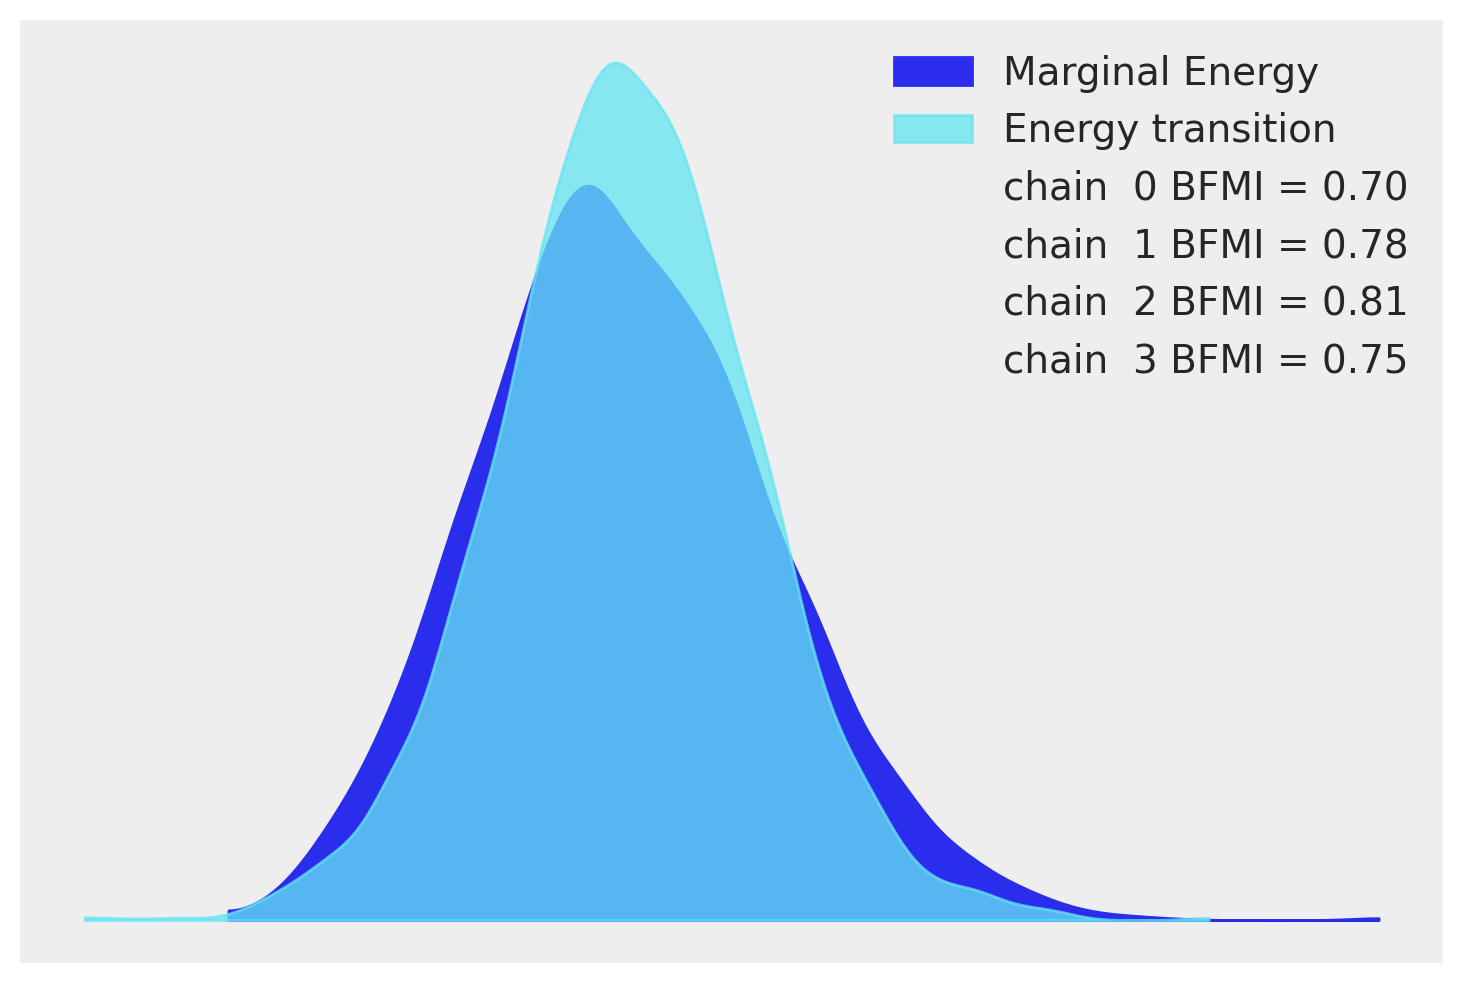

In [24]:
az.plot_energy(idata);

Ultimately, we are interested in the estimates of `beta`, the set of predictor coefficients. Passing `beta` to `plot_trace` would generate a very crowded plot, so we will use `plot_forest` instead, which is designed to handle vector-valued parameters.

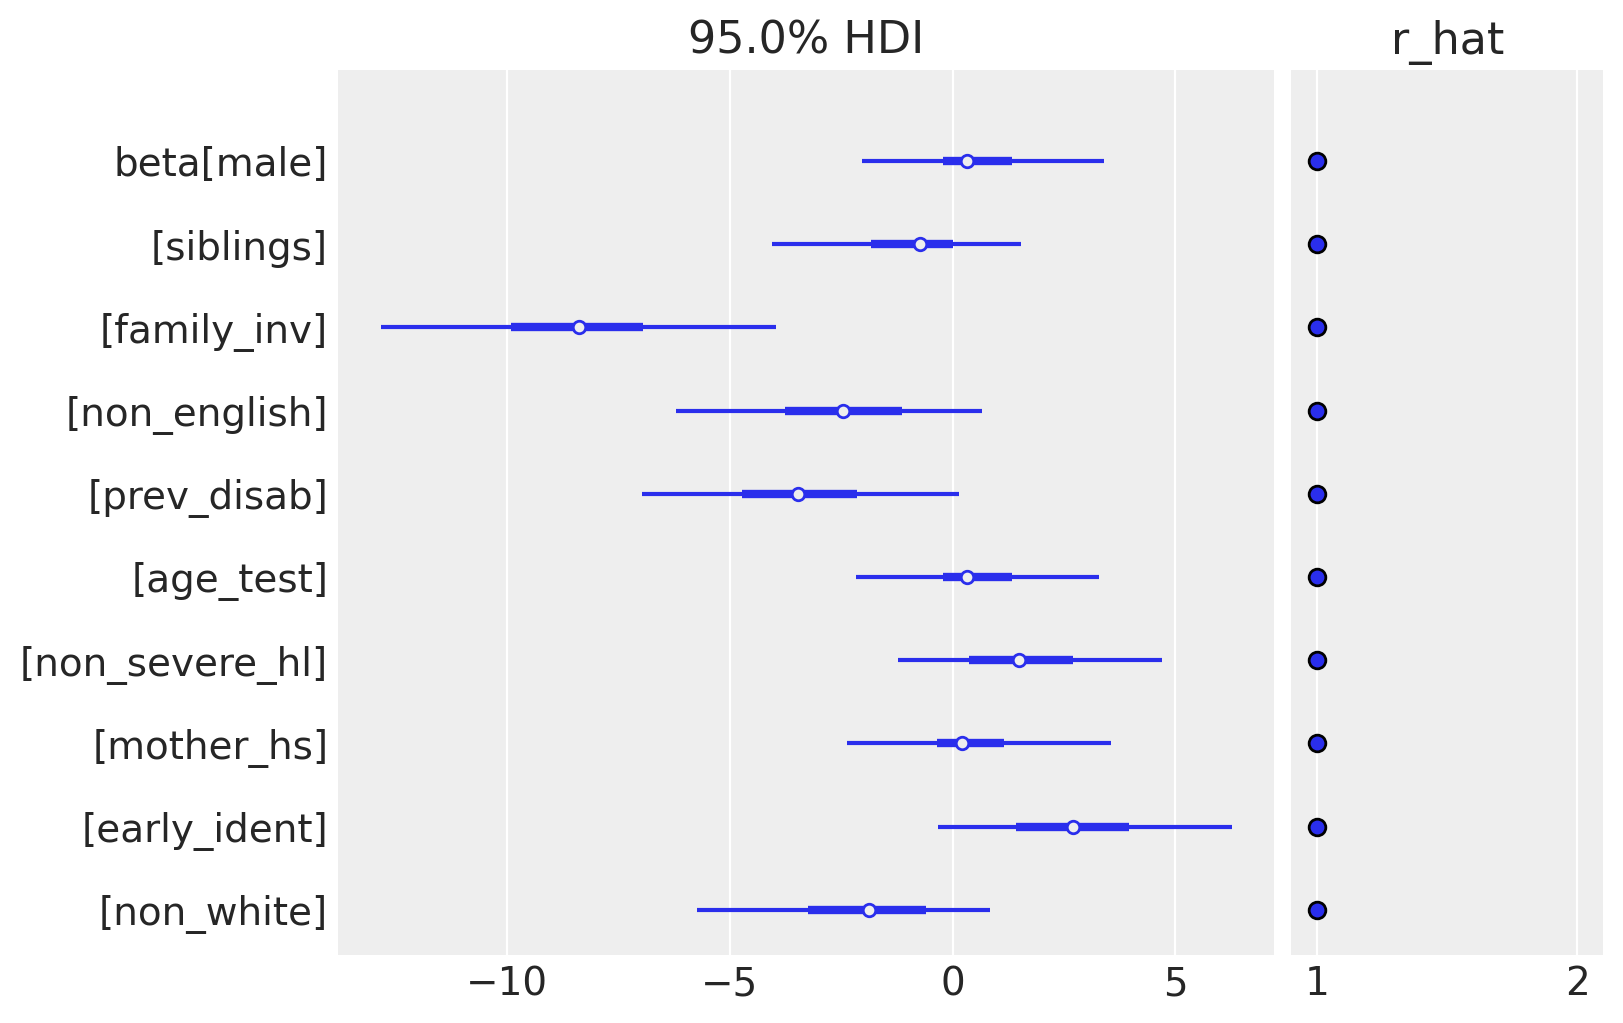

In [25]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

The posterior distribution of coefficients reveal some factors that appear to be important in predicting test scores. Family involvement (`family_inv`) is large and negative, meaning a largr score (which is related to poorer involvement) results in much worse test scores. On the other end, early identification of hearing impairment is positive, meaning that detecting a problem early results in better educational outcomes down the road, which is also intuitive. Notice that other variables, notably gender (`male`), age at testing (`age_test`), and the mother's educational status (`mother_hs`) have all been shrunk essentially to zero.

## Case study 2: Coal mining disasters

Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period. Unfortunately, we also have pair of years with missing data, identified as missing by a `nan` in the pandas `Series`. These missing values will be automatically imputed by PyMC. 

Next we will build a model for this series and attempt to estimate when the change occurred. At the same time, we will see how to handle missing data, use multiple samplers and sample from discrete random variables. 

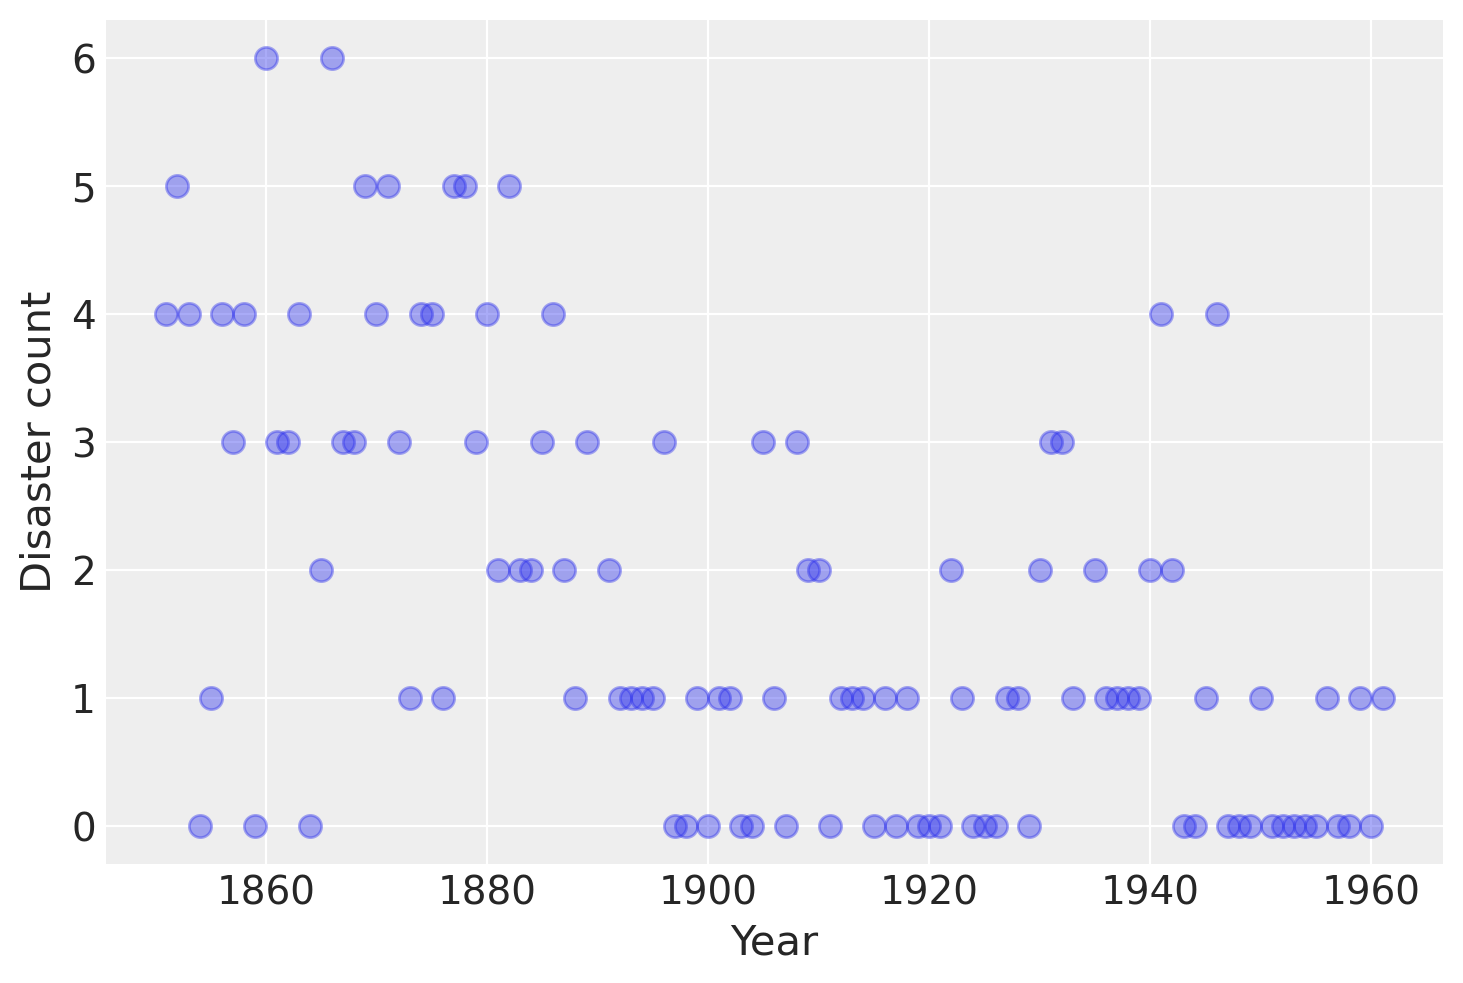

In [26]:
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

Occurrences of disasters in the time series is thought to follow a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.

In our model, 

$$ 
\begin{aligned}  
  D_t &\sim \text{Pois}(r_t), r_t= \begin{cases} 
   e, & \text{if } t \le s \\
   l, & \text{if } t \gt s 
   \end{cases} \\
  s &\sim \text{Unif}(t_l, t_h)\\         
  e &\sim \text{exp}(1)\\
  l &\sim \text{exp}(1)    
\end{aligned}
$$

the parameters are defined as follows: 
   * $D_t$: The number of disasters in year $t$
   * $r_t$: The rate parameter of the Poisson distribution of disasters in year $t$.
   * $s$: The year in which the rate parameter changes (the switchpoint).
   * $e$: The rate parameter before the switchpoint $s$.
   * $l$: The rate parameter after the switchpoint $s$.
   * $t_l$, $t_h$: The lower and upper boundaries of year $t$.
   
This model is built much like our previous models. The major differences are the introduction of discrete variables with the Poisson and discrete-uniform priors and the novel form of the deterministic random variable `rate`.

In [27]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform(
        "switchpoint", lower=years.min(), upper=years.max()
    )

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/home/fonnesbeck/miniforge3/envs/dev/lib/python3.9/site-packages/pymc/model.py:1299: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


The logic for the rate random variable,
```python
rate = switch(switchpoint >= year, early_rate, late_rate)
```
is implemented using `switch`, a function that works like an if statement. It uses the first argument to switch between the next two arguments.

Missing values are handled transparently by passing a NumPy {class}`~numpy.MaskedArray` or a {class}`~pandas.DataFrame` with NaN values to the `observed` argument when creating an observed stochastic random variable. Behind the scenes, another random variable, `disasters.missing_values` is created to model the missing values.

Unfortunately because they are discrete variables and thus have no meaningful gradient, we cannot use NUTS for sampling `switchpoint` or the missing disaster observations. Instead, we will sample using a {class}`~pymc.Metroplis` step method, which implements adaptive Metropolis-Hastings, because it is designed to handle discrete values. PyMC automatically assigns the correct sampling algorithms.

In [28]:
with disaster_model:
    idata = pm.sample(10000)

/home/fonnesbeck/miniforge3/envs/dev/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
/home/fonnesbeck/miniforge3/envs/dev/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
/home/fonnesbeck/miniforge3/envs/dev/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint]
>>Metropolis: [disasters_missing]
>NUTS: [early_rate, late_rate]
/home/fonnesbeck/miniforge3/envs/dev/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 22 seconds.
The number of effective samples is smaller than 10% for some parameters.


In the trace plot below we can see that there's about a 10 year span that's plausible for a significant change in safety, but a 5 year span that contains most of the probability mass. The distribution is jagged because of the jumpy relationship between the year switchpoint and the likelihood  and not due to sampling error.

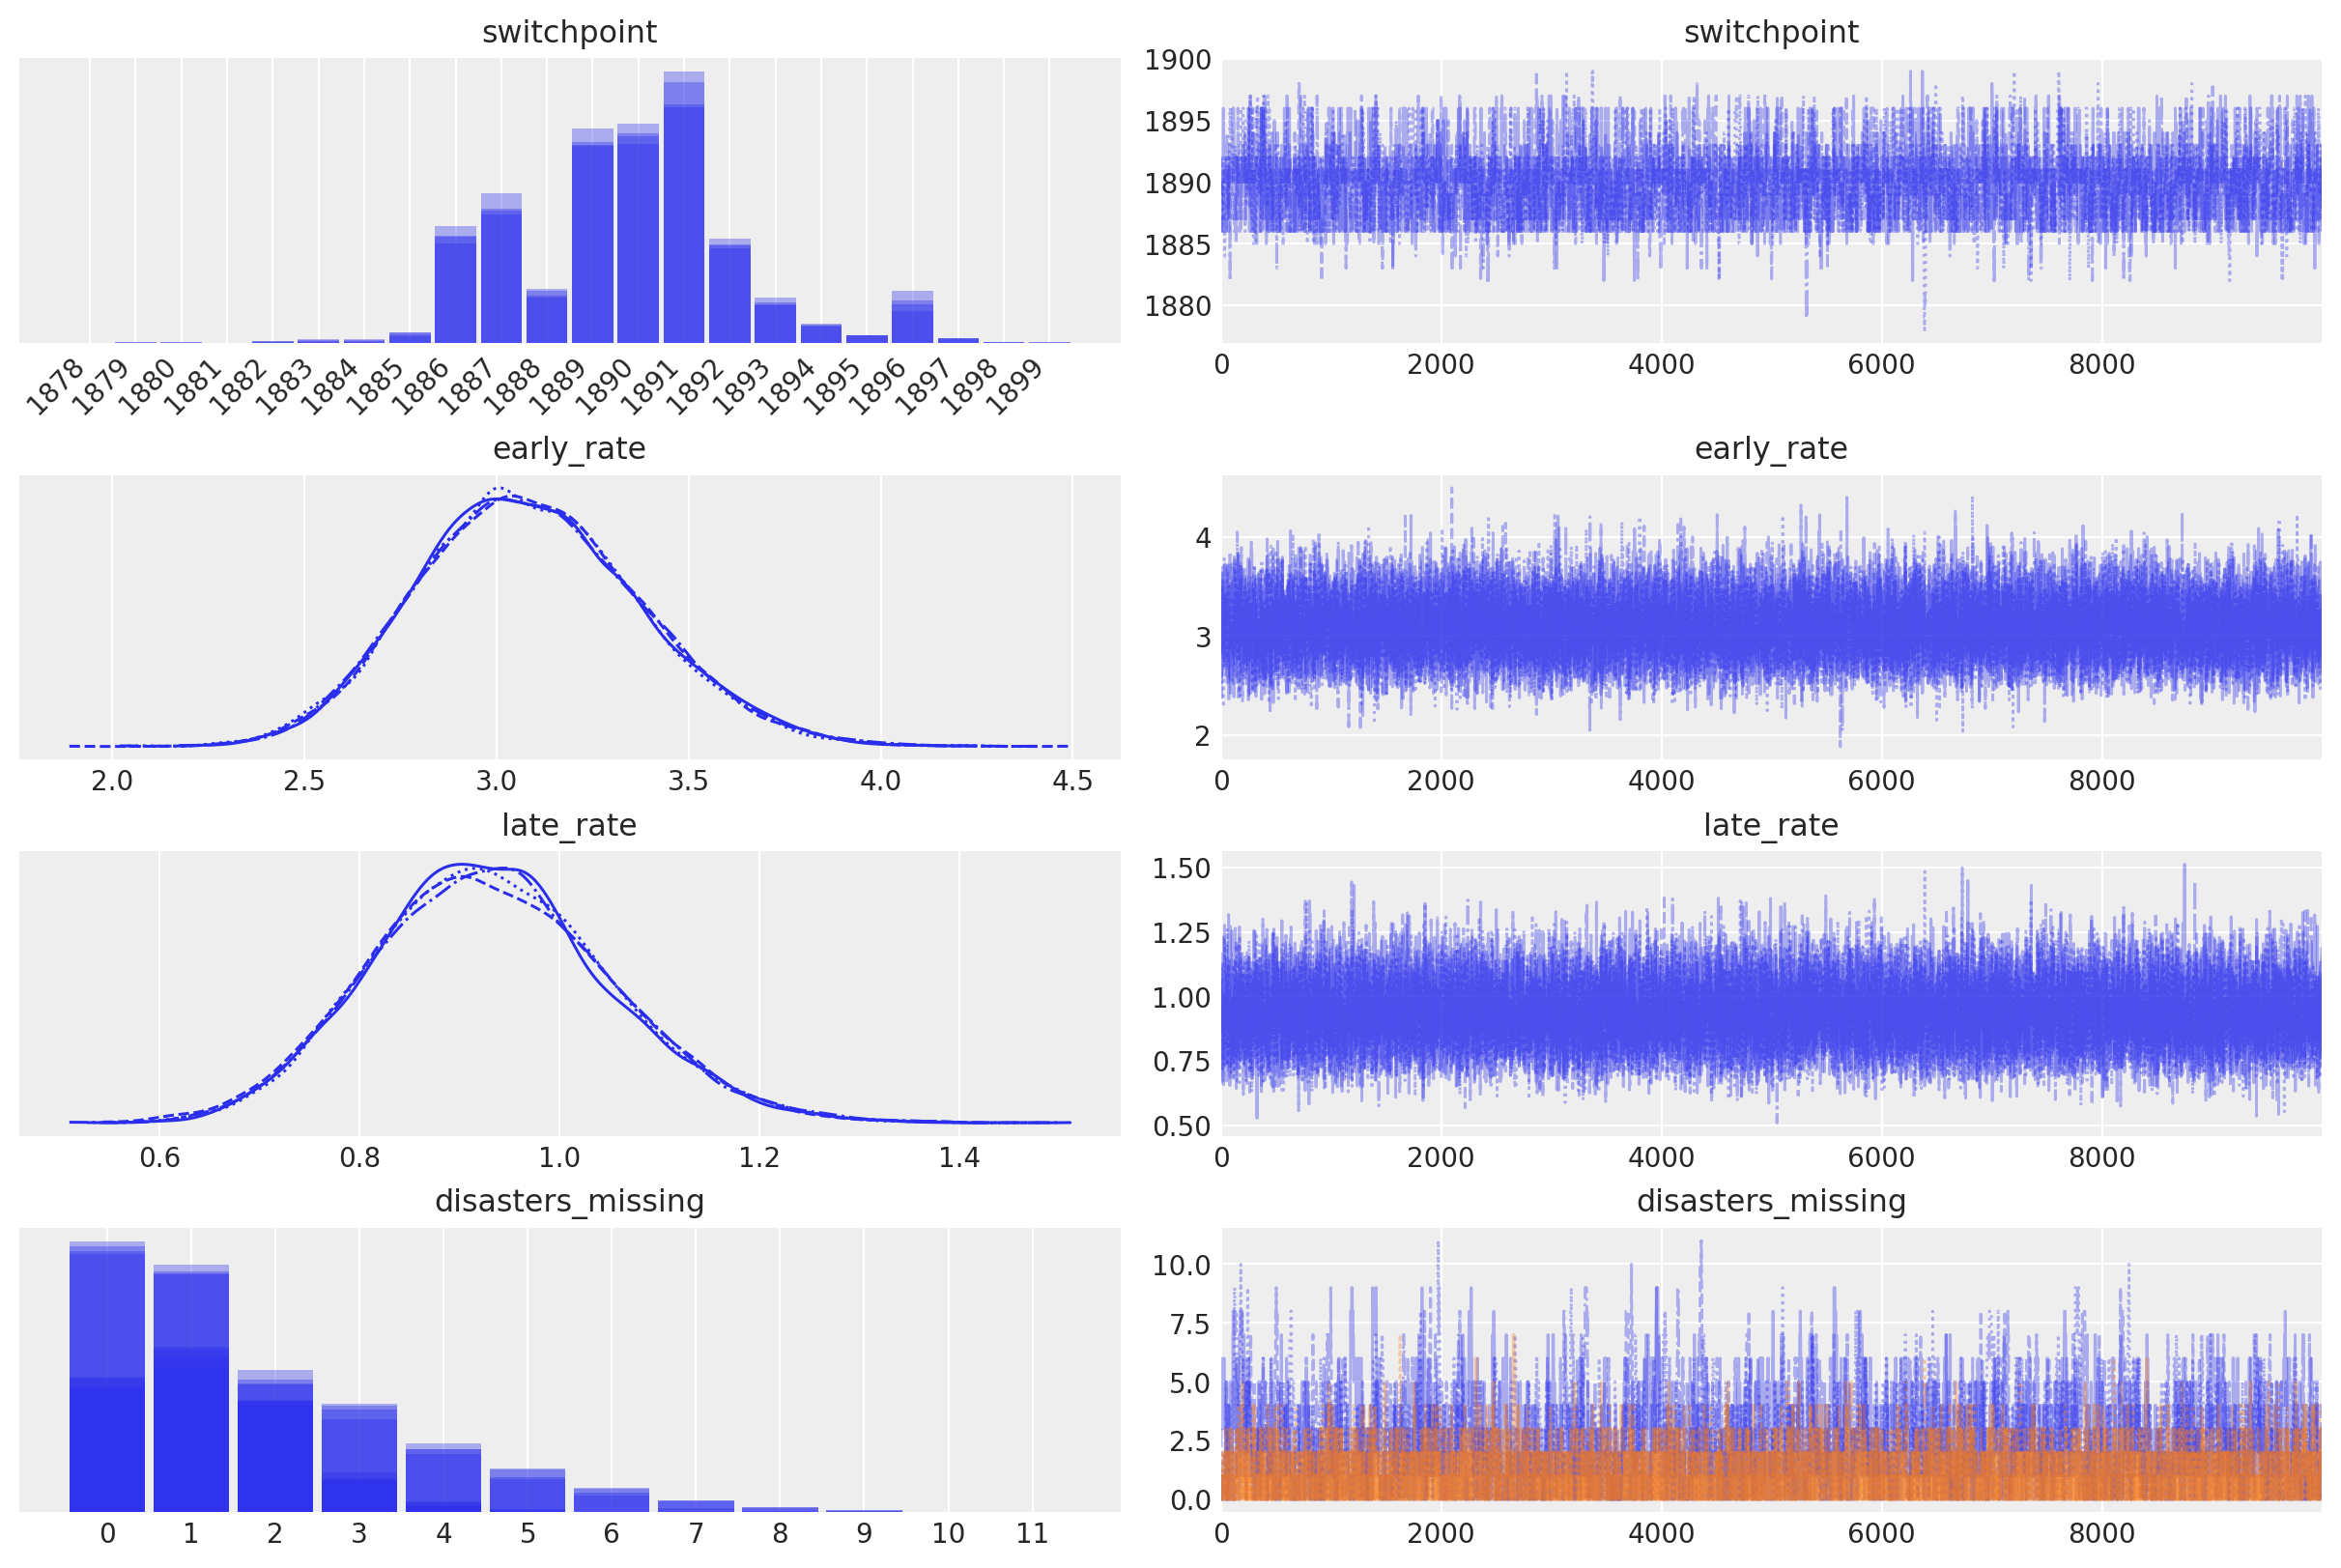

In [29]:
axes_arr = az.plot_trace(idata)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()


Note that the `rate` random variable does not appear in the trace.  That is fine in this case, because it is not of interest in itself.  Remember from the previous example, we would trace the variable by wrapping it in a {class}`~pymc.Deterministic` class, and giving it a name.:

The following plot shows the switch point as an orange vertical line, together with its HPD as a semitransparent band. The dashed black line shows the accident rate.

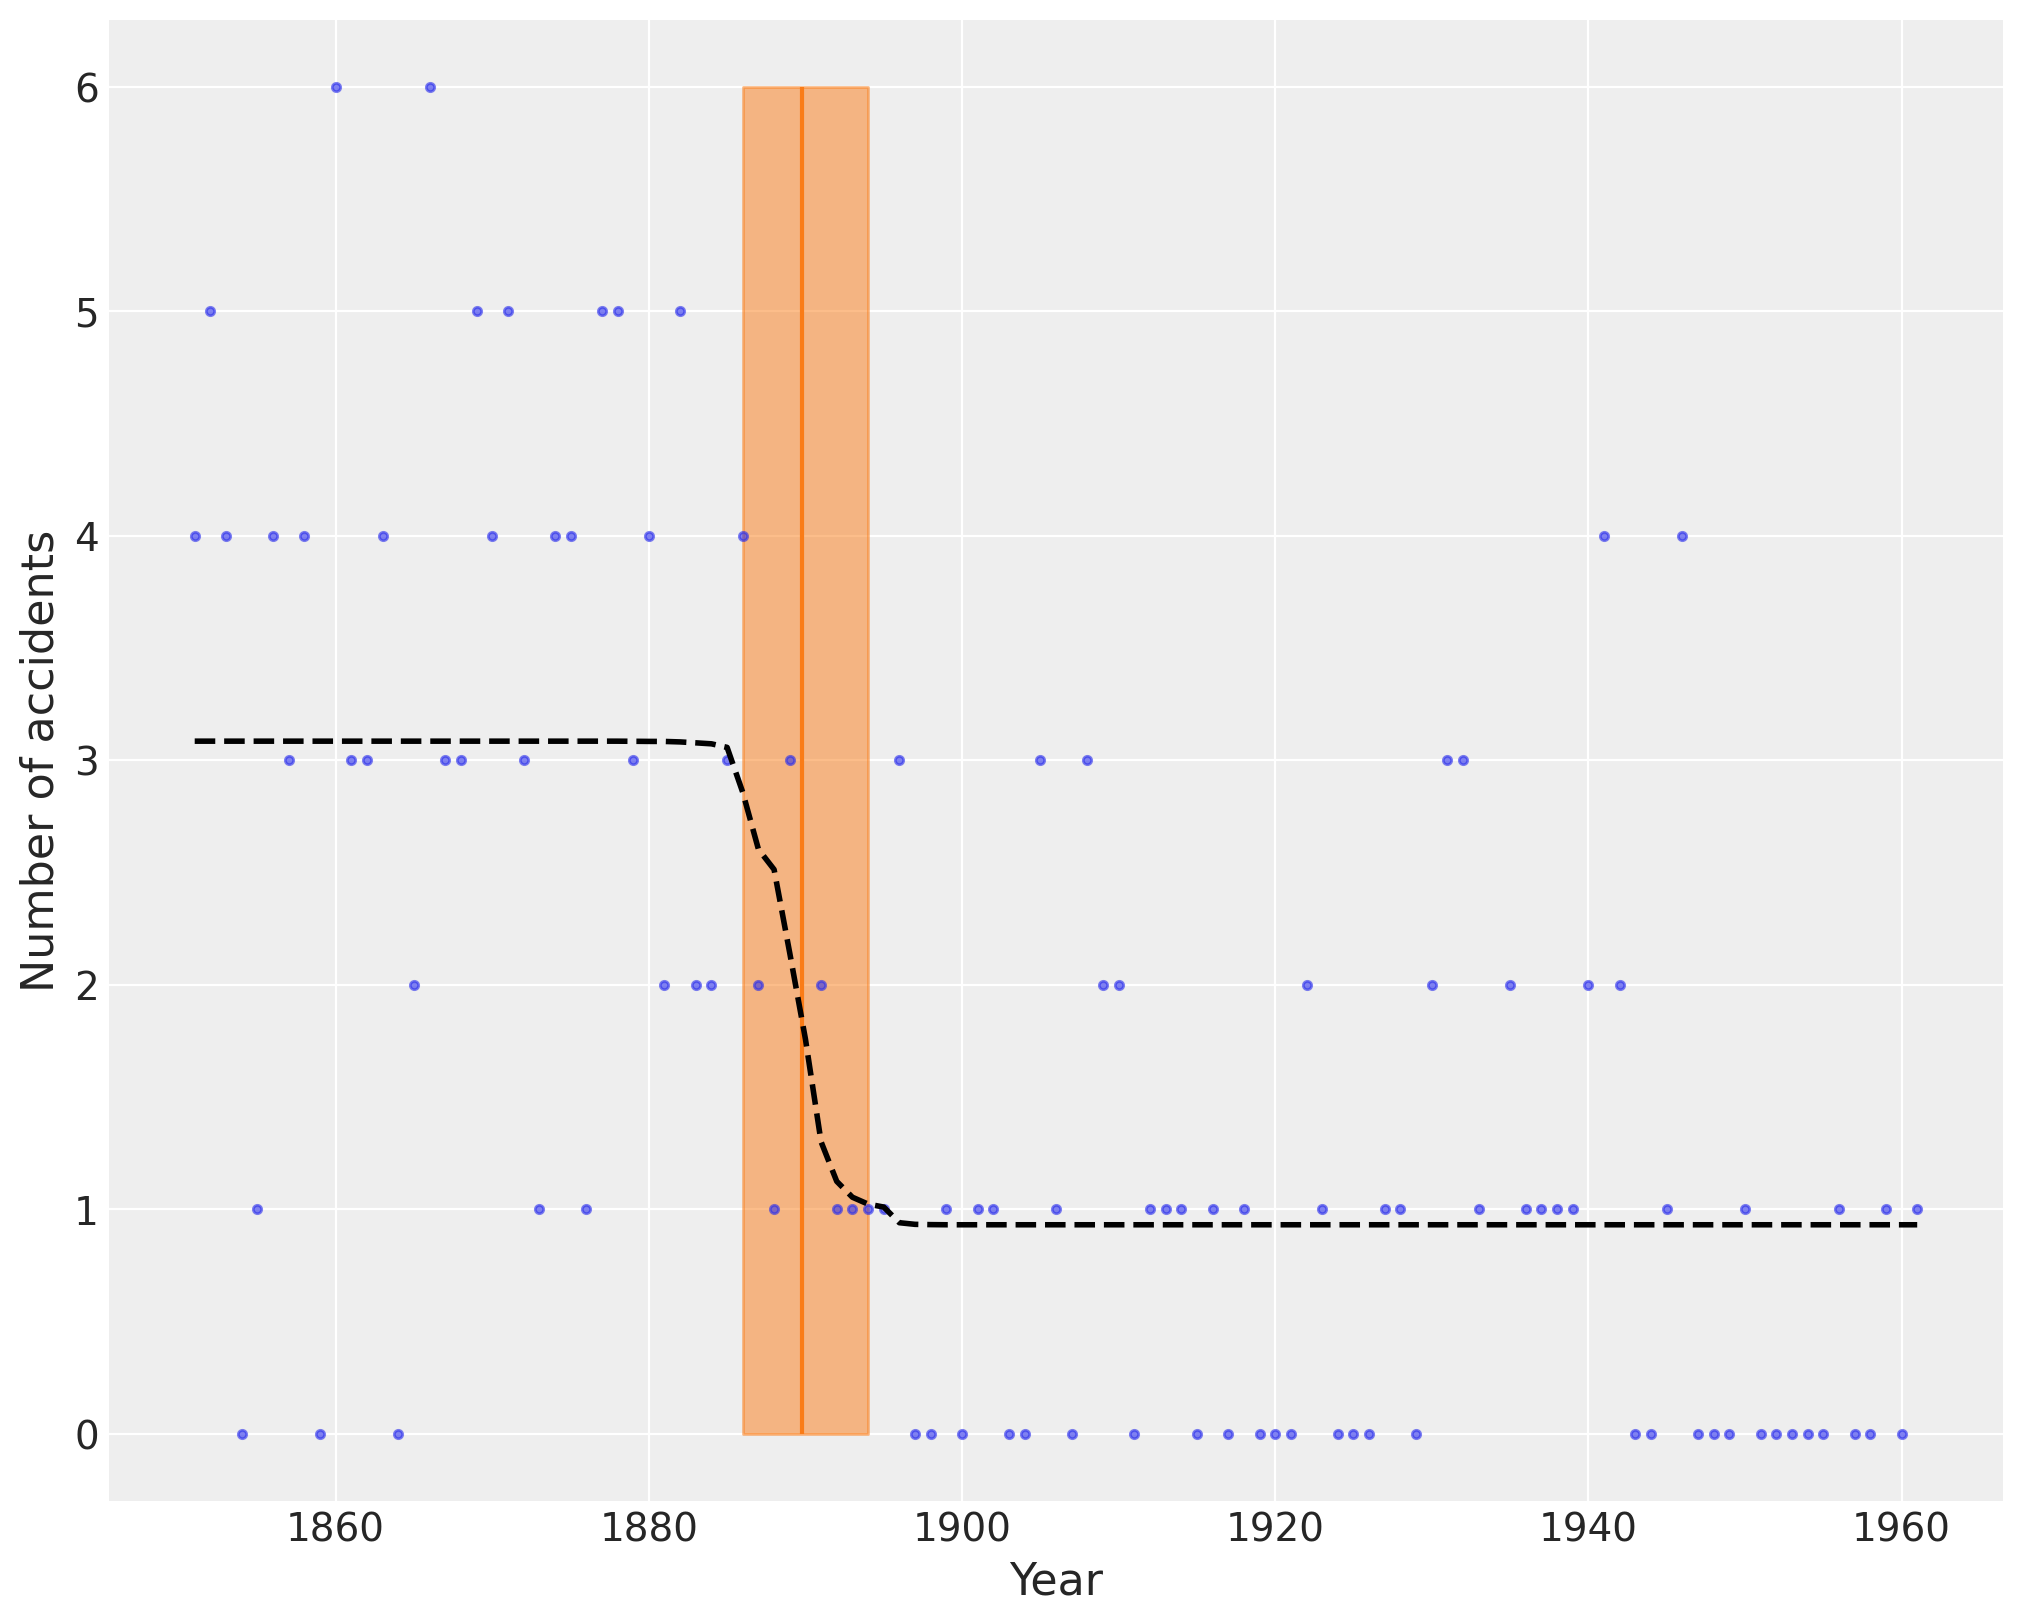

In [30]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(idata, var_names=["switchpoint"])["switchpoint"].values
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);

## Arbitrary deterministics

Due to its reliance on Aesara, PyMC provides many mathematical functions and operators for transforming random variables into new random variables. However, the library of functions in Aesara is not exhaustive, therefore Aesara and PyMC provide functionality for creating arbitrary functions in pure Python, and including these functions in PyMC models. This is supported with the `as_op` function decorator.

Aesara needs to know the types of the inputs and outputs of a function, which are specified for `as_op` by `itypes` for inputs and `otypes` for outputs. 

In [31]:

from aesara.compile.ops import as_op

@as_op(itypes=[at.lscalar], otypes=[at.lscalar])
def crazy_modulo3(value):
    if value > 0:
        return value % 3
    else:
        return (-value + 1) % 3


with pm.Model() as model_deterministic:
    a = pm.Poisson("a", 1)
    b = crazy_modulo3(a)

An important drawback of this approach is that it is not possible for `aesara` to inspect these functions in order to compute the gradient required for the Hamiltonian-based samplers. Therefore, it is not possible to use the HMC or NUTS samplers for a model that uses such an operator. However, it is possible to add a gradient if we inherit from {class}`~aesara.Op` instead of using `as_op`. The PyMC example set includes [a more elaborate example of the usage of as_op](https://github.com/pymc-devs/pymc-examples/blob/main/examples/case_studies/disaster_model_theano_op.py).

## Arbitrary distributions

Similarly, the library of statistical distributions in PyMC is not exhaustive, but PyMC allows for the creation of user-defined functions for an arbitrary probability distribution. For simple statistical distributions, the {class}`~pymc.DensityDist` class takes as an argument any function that calculates a log-probability $log(p(x))$. This function may employ other random variables in its calculation. Here is an example inspired by a blog post by Jake Vanderplas on which priors to use for a linear regression (Vanderplas, 2014). 

```python
import aesara.tensor as at

with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)
    
    # Create custom densities
    beta = pm.DensityDist('beta', logp=lambda value: -1.5 * at.log(1 + value**2))
    eps = pm.DensityDist('eps', logp=lambda value: -at.log(at.abs_(value)))
    
    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * X, sigma=eps, observed=Y)
```

For more complex distributions, one can create a subclass of {class}`~pymc.Continuous` or {class}`~pymc.Discrete` and provide the custom `logp` function, as required. This is how the built-in distributions in PyMC are specified. As an example, fields like psychology and astrophysics have complex likelihood functions for a particular process that may require numerical approximation. 

Implementing the `beta` variable above as a `Continuous` subclass is shown below, along with an associated {class}`~aesara.RandomVariable` object, an instance of which becomes an attribute of the distribution.

In [32]:
class BetaRV(at.random.op.RandomVariable):
    name = "beta"
    ndim_supp = 0
    ndims_params = []
    dtype = "floatX"

    @classmethod
    def rng_fn(cls, rng, size):
        raise NotImplementedError("Cannot sample from beta variable")


beta = BetaRV()


In [33]:
class Beta(pm.Continuous):

    rv_op = beta

    @classmethod
    def dist(cls, mu=0, **kwargs):        
        mu = at.as_tensor_variable(mu)
        return super().dist([mu], **kwargs)


    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)


def beta_logp(value):
    return -1.5 * at.log(1 + (value) ** 2)


with pm.Model() as model:
    beta = Beta("beta", mu=0)

If your logp can not be expressed in Aesara, you can decorate the function with `as_op` as follows: `@as_op(itypes=[at.dscalar], otypes=[at.dscalar])`. Note, that this will create a blackbox Python function that will be much slower and  not provide the gradients necessary for e.g. NUTS.

## Discussion

Probabilistic programming is an emerging paradigm in statistical learning, of which Bayesian modeling is an important sub-discipline. The signature characteristics of probabilistic programming--specifying variables as probability distributions and conditioning variables on other variables and on observations--makes it a powerful tool for building models in a variety of settings, and over a range of model complexity. Accompanying the rise of probabilistic programming has been a burst of innovation in fitting methods for Bayesian models that represent notable improvement over existing MCMC methods. Yet, despite this expansion, there are few software packages available that have kept pace with the methodological innovation, and still fewer that allow non-expert users to implement models.

PyMC provides a probabilistic programming platform for quantitative researchers to implement statistical models flexibly and succinctly. A large library of statistical distributions and several pre-defined fitting algorithms allows users to focus on the scientific problem at hand, rather than the implementation details of Bayesian modeling. The choice of Python as a development language, rather than a domain-specific language, means that PyMC users are able to work interactively to build models, introspect model objects, and debug or profile their work, using a dynamic, high-level programming language that is easy to learn. The modular, object-oriented design of PyMC means that adding new fitting algorithms or other features is straightforward. In addition, PyMC comes with several features not found in most other packages, most notably Hamiltonian-based samplers as well as automatical transforms of constrained random variables which is only offered by Stan. Unlike Stan, however, PyMC supports discrete variables as well as non-gradient based sampling algorithms like Metropolis-Hastings and Slice sampling.

Development of PyMC is an ongoing effort and several features are planned for future versions. Most notably, variational inference techniques are often more efficient than MCMC sampling, at the cost of generalizability. More recently, however, black-box variational inference algorithms have been developed, such as automatic differentiation variational inference (ADVI; Kucukelbir et al., 2017). This algorithm is slated for addition to PyMC. As an open-source scientific computing toolkit, we encourage researchers developing new fitting algorithms for Bayesian models to provide reference implementations in PyMC. Since samplers can be written in pure Python code, they can be implemented generally to make them work on arbitrary PyMC models, giving authors a larger audience to put their methods into use.

## References

Bastien, F., Lamblin, P., Pascanu, R., Bergstra, J., Goodfellow, I., Bergeron, A., Bouchard, N., Warde-Farley, D., and Bengio, Y. (2012) “Theano: new features and speed improvements”. NIPS 2012 deep learning workshop.

Bergstra, J., Breuleux, O., Bastien, F., Lamblin, P., Pascanu, R., Desjardins, G., Turian, J., Warde-Farley, D., and Bengio, Y. (2010) “Theano: A CPU and GPU Math Expression Compiler”. Proceedings of the Python for Scientific Computing Conference (SciPy) 2010. June 30 - July 3, Austin, TX

Duane, S., Kennedy, A. D., Pendleton, B. J., and Roweth, D. (1987) “Hybrid Monte Carlo”, Physics Letters, vol. 195, pp. 216-222.

Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research, 30.

Jarrett, R.G. A note on the intervals between coal mining disasters. Biometrika, 66:191–193, 1979.

[Kucukelbir A, Dustin Tran, Ranganath R, Gelman A, and Blei DM. Automatic differentiation variational inference,  The Journal of Machine Learning Research. 18 , pp. 430-474.](http://arxiv.org/abs/1506.03431)

Lunn, D.J., Thomas, A., Best, N., and Spiegelhalter, D. (2000) WinBUGS -- a Bayesian modelling framework: concepts, structure, and extensibility. Statistics and Computing, 10:325--337.

Neal, R.M. Slice sampling. Annals of Statistics. (2003). doi:10.2307/3448413.
Patil, A., D. Huard and C.J. Fonnesbeck. (2010) PyMC: Bayesian Stochastic Modelling in Python. Journal of Statistical Software, 35(4), pp. 1-81

[Piironen, J., & Vehtari, A. (2017). Sparsity information and regularization in the horseshoe and other shrinkage priors. _Electronic Journal of Statistics_, 11(2), 5018-5051.](https://projecteuclid.org/journals/electronic-journal-of-statistics/volume-11/issue-2/Sparsity-information-and-regularization-in-the-horseshoe-and-other-shrinkage/10.1214/17-EJS1337SI.full)

[Stan Development Team. (2014). Stan: A C++ Library for Probability and Sampling, Version 2.5.0.](http://mc-stan.org)

[Vanderplas, Jake. "Frequentism and Bayesianism IV: How to be a Bayesian in Python." Pythonic Perambulations. N.p., 14 Jun 2014. Web. 27 May. 2015.](https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python)


In [34]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Dec 30 2021

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.30.1

sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]
aesara    : 2.3.2
matplotlib: 3.5.1
pymc      : 4.0.0b1
arviz     : 0.11.4
pandas    : 1.3.5
numpy     : 1.21.4

Watermark: 2.2.0

